# Оптимизация

## Установка пакетов

In [2]:
!git clone https://github.com/orpatashnik/StyleCLIP.git

import os
os.chdir(f'./StyleCLIP')

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

fatal: целевой путь «StyleCLIP» уже существует и не является пустым каталогом.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-tmgeyh1q
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-tmgeyh1q
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
!pip install gdown

!gdown https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
!mv stylegan2-ffhq-config-f.pt pretrained_models


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Downloading...
From (original): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
From (redirected): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT&confirm=t&uuid=79ee67e0-39f3-4adc-880e-841b06fb02a8
To: /home/vlad/StyleCLIP-main/new_notebooks/StyleCLIP/stylegan2-ffhq-config-f.pt
100%|█████████████████████████████████████████| 381M/381M [13:13<00:00, 481kB/s]


In [3]:
!gdown https://drive.google.com/uc?id=1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL
!mv model_ir_se50.pth pretrained_models

Downloading...
From (original): https://drive.google.com/uc?id=1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL
From (redirected): https://drive.google.com/uc?id=1N0MZSqPRJpLfP4mFQCS14ikrVSe8vQlL&confirm=t&uuid=f2695443-b382-4333-9d41-ad403a6d7e34
To: /home/vlad/StyleCLIP-main/new_notebooks/StyleCLIP/model_ir_se50.pth
100%|█████████████████████████████████████████| 175M/175M [06:15<00:00, 467kB/s]


## Если они установлены

In [1]:
import os
os.chdir(f'./StyleCLIP')

In [2]:
import torch
import torchvision.transforms as T
from tqdm.notebook import tqdm
from models.stylegan2.model import Generator #StyleGAN
import ipywidgets as widgets
import clip #CLIP
from models.facial_recognition.model_irse import Backbone #ArcFace

## Загрузка готовых моделей

In [3]:
def check_high_mem_gpu(size):
    return torch.cuda.get_device_properties(0).total_memory > size * 1024**3

device1 = "cuda" if torch.cuda.is_available() else "cpu"
# Запускаем CLIP на ЦП, если мало видеопамяти
device2 = "cuda" if torch.cuda.is_available() and check_high_mem_gpu(3) else "cpu"
device3 = "cuda" if torch.cuda.is_available() else "cpu"

sg_weights = "pretrained_models/stylegan2-ffhq-config-f.pt"
af_weighs = "pretrained_models/model_ir_se50.pth"

# Чем больше видеопамяти - тем выше качество картинки
if check_high_mem_gpu(7):
    sg = Generator(1024, 512, 8)
if check_high_mem_gpu(6):
    sg = Generator(512, 512, 8)
elif check_high_mem_gpu(5):
    sg = Generator(256, 512, 8)
elif check_high_mem_gpu(4):
    sg = Generator(128, 512, 8)
else:
    sg = Generator(64, 512, 8)
sg.load_state_dict(torch.load(sg_weights)["g_ema"], strict = False)
sg = sg.to(device1)
cl_m, _ = clip.load("ViT-B/32", device = device2)
af = Backbone(input_size = 112, num_layers = 50, drop_ratio = 0.6, mode = "ir_se")
af.load_state_dict(torch.load(af_weighs))
af = af.to(device3)

/tmp/ipykernel_44080/1055657627.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sg.load_state_dict(torch.load(sg_weights)["g_ema"], strict = False)
/tmp/ipykernel_44080

## Функции потерь

In [4]:
def preprocess_img(img):
    dim = img.shape[2]
    mult = 224 / dim
    upsample = torch.nn.Upsample(scale_factor = mult)
    pre_img = upsample(img)
    return pre_img

def clip_loss(img_emb, text_emb):
    return 1 - cl_m(img_emb, text_emb)[0] / 100

def l2_loss(w_coef, w_pred, w_true):
    return w_coef * torch.norm(w_pred - w_true, p = 2).cpu()

def id_regul(w_coef, emb_pred, emb_true):
    emb_pred = emb_pred.reshape(-1, 3, 112, 112).to(device3)
    emb_true = emb_true.reshape(-1, 3, 112, 112).to(device3)
    face_pred = af(emb_pred).cpu().flatten()
    face_true = af(emb_true).cpu().flatten()
    return w_coef * (1 - torch.dot(face_pred, face_true.T))

def total_loss(w_coef1, w_coef2, source_latent, my_latent, source_img_emb, my_img_emb, text_emb):
    pre_img_0 = preprocess_img(source_img_emb)
    pre_img = preprocess_img(my_img_emb)
    first = clip_loss(pre_img, text_emb)
    second = l2_loss(w_coef1, source_latent, my_latent)
    third = id_regul(w_coef2, pre_img, pre_img_0)
    return first + second + third

In [5]:
criterion = total_loss

## Оптимизация

In [6]:
from copy import copy

def copy_tensor(t):
    s = t.detach().clone()
    s.requires_grad = True
    return s

def set_lr(lr, cur_lr, part):
    if part < 0.1:
        return lr * part / 0.1
    elif part > 0.6:
        return lr * (1 - part) / 0.4
    else:
        return lr

def optimize(w_coef1, w_coef2, source_latent, source_img_emb = torch.empty((0, 1)), epochs = 50, lr = 0.1):
    sg.eval()
    losses = []
    my_latent = copy_tensor(source_latent)
    text_emb = torch.cat([clip.tokenize(text)]).to(device2)
    optimizer = torch.optim.AdamW([my_latent], lr = lr)
    cur_lr = copy(lr)
    real = bool(len(source_img_emb))
    
    for epoch in tqdm(range(epochs)):
        print(f"Итерация: {epoch}")
        if not real:
            source_img_emb, _ = sg([source_latent.to(device1)], input_is_latent = True)
        my_img_emb, _ = sg([my_latent.to(device1)], input_is_latent = True)
        loss = criterion(w_coef1, w_coef2, source_latent, my_latent, source_img_emb, my_img_emb, text_emb)
        optimizer.zero_grad()
        loss.backward()
        if len(losses):
            cur_lr = set_lr(lr, cur_lr, epoch / epochs)
        optimizer.param_groups[0]["lr"] = lr
        optimizer.step()
        losses.append(loss.item())
    
    my_img = my_img_emb.detach().cpu()
    return my_img, losses

In [7]:
Epochs = widgets.BoundedIntText(
    value = 50,
    min = 20,
    max = 500,
    step = 5,
    description = "Итераций:",
    disabled = False
)

Lr = widgets.BoundedFloatText(
    value = 0.1,
    min = 0.0001,
    max = 1,
    step = 0.0001,
    description = "Скорость обучения:",
    disabled = False
)

W_coef1 = widgets.BoundedFloatText(
    value = 0.008,
    min = 0.001,
    max = 0.01,
    step = 0.001,
    description = "$Lambda_{L2}:$",
    disabled = False
)

W_coef2 = widgets.BoundedFloatText(
    value = 0.005,
    min = 0.001,
    max = 0.01,
    step = 0.001,
    description = "$Lambda_{ID}:$",
    disabled = False
)

Text = widgets.Text(
    value = "High middle-aged woman",
    placeholder = "Введите описание:",
    disabled = False
)

display(Epochs)
display(Lr)
display(W_coef1)
display(W_coef2)
display(Text)

epochs = Epochs.value
lr = Lr.value
w_coef1 = W_coef1.value
w_coef2 = W_coef2.value
text = Text.value

BoundedIntText(value=50, description='Итераций:', max=500, min=20, step=5)

BoundedFloatText(value=0.1, description='Скорость обучения:', max=1.0, min=0.0001, step=0.0001)

BoundedFloatText(value=0.008, description='$Lambda_{L2}:$', max=0.01, min=0.001, step=0.001)

BoundedFloatText(value=0.005, description='$Lambda_{ID}:$', max=0.01, min=0.001, step=0.001)

Text(value='High middle-aged woman', placeholder='Введите описание:')

In [8]:
z0 = torch.randn(1, 512)
z = z0.to(device1)
with torch.no_grad():
    img0, lat, _ = sg([z], return_latents = True)
img0 = img0.detach().cpu()
torch.cuda.empty_cache()

img, losses = optimize(w_coef1, w_coef2, lat, epochs = epochs, lr = lr)
img0 = torch.permute(img0, (0, 2, 3, 1))
img = torch.permute(img, (0, 2, 3, 1))

  0%|          | 0/50 [00:00<?, ?it/s]

Итерация: 0


/tmp/ipykernel_44080/4069245929.py:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  return w_coef * (1 - torch.dot(face_pred, face_true.T))


Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49


## Сравнение изображений

In [9]:
def normalize(cur_img):
    min_img = cur_img.min()
    max_img = cur_img.max()
    cur_img -= min_img
    diff_img = max_img - min_img
    cur_img /= diff_img
    return cur_img

img0 = normalize(img0)
img = normalize(img)

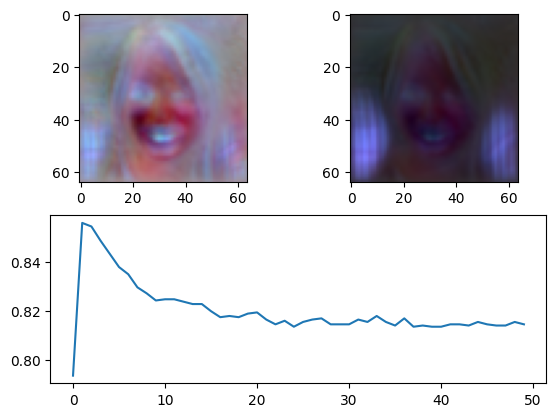

In [10]:
import matplotlib.pyplot as plt

plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()

Есть попытка сгенерировать женщину, но она не очень удачная.

# Эксперименты

### Эксперимент 1

Меняем скорость обучения

In [11]:
lr = 0.4

img, losses = optimize(w_coef1, w_coef2, lat, epochs = epochs, lr = lr)
img = torch.permute(img, (0, 2, 3, 1))

img = normalize(img)

  0%|          | 0/50 [00:00<?, ?it/s]

Итерация: 0
Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49


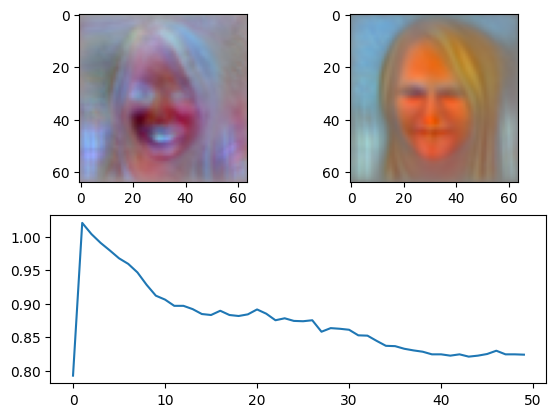

In [12]:
plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()

Результат ещё хуже предыдущего.

### Эксперимент 2

Увеличим количество итераций.

In [13]:
epochs = 200

img, losses = optimize(w_coef1, w_coef2, lat, epochs = epochs, lr = lr)
img = torch.permute(img, (0, 2, 3, 1))

img = normalize(img)

  0%|          | 0/200 [00:00<?, ?it/s]

Итерация: 0
Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49
Итерация: 50
Итерация: 51
Итерация: 52
Итерация: 53
Итерация: 54
Итерация: 55
Итерация: 56
Итерация: 57
Итерация: 58
Итерация: 59
Итерация: 60
Итерация: 61
Итерация: 62
Итерация: 63
Итерация: 64
Итерация: 65
Итерация: 66
Итерация: 67
Итерация: 68
Итерация: 69
Итерация: 70
Итерация: 71
Итерация: 72
Итерация: 73
Итерация: 74
Итерация: 75
Итерация: 76
Итерация:

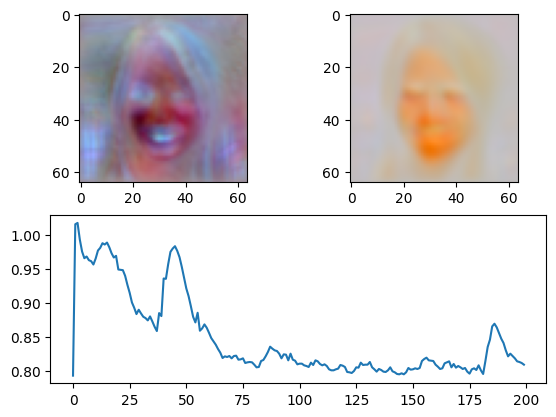

In [14]:
plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()

Увеличение количество итераций не помогло (очень неустойчивая тренировка).

### Эксперимент 3

Поменяем коээфициенты для функции потерь.

In [15]:
w_coef1 = 0.005
w_coef2 = 0.008

img, losses = optimize(w_coef1, w_coef2, lat, epochs = epochs, lr = lr)
img = torch.permute(img, (0, 2, 3, 1))

img = normalize(img)

  0%|          | 0/200 [00:00<?, ?it/s]

Итерация: 0
Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49
Итерация: 50
Итерация: 51
Итерация: 52
Итерация: 53
Итерация: 54
Итерация: 55
Итерация: 56
Итерация: 57
Итерация: 58
Итерация: 59
Итерация: 60
Итерация: 61
Итерация: 62
Итерация: 63
Итерация: 64
Итерация: 65
Итерация: 66
Итерация: 67
Итерация: 68
Итерация: 69
Итерация: 70
Итерация: 71
Итерация: 72
Итерация: 73
Итерация: 74
Итерация: 75
Итерация: 76
Итерация:

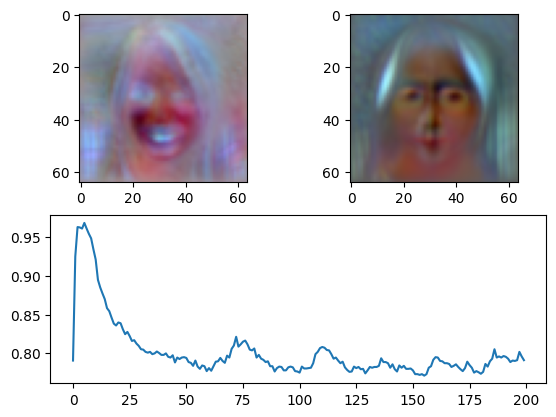

In [16]:
plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()

Около 190 итерации есть сносный (< 0.8) результат. При этом лицо более узнаваемо, чем в предыдущих случаях.

### Эксперимент 4

Вернём скорость обучения на изначальную.

In [17]:
lr = 0.1

img, losses = optimize(w_coef1, w_coef2, lat, epochs = epochs, lr = lr)
img = torch.permute(img, (0, 2, 3, 1))

img = normalize(img)

  0%|          | 0/200 [00:00<?, ?it/s]

Итерация: 0
Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49
Итерация: 50
Итерация: 51
Итерация: 52
Итерация: 53
Итерация: 54
Итерация: 55
Итерация: 56
Итерация: 57
Итерация: 58
Итерация: 59
Итерация: 60
Итерация: 61
Итерация: 62
Итерация: 63
Итерация: 64
Итерация: 65
Итерация: 66
Итерация: 67
Итерация: 68
Итерация: 69
Итерация: 70
Итерация: 71
Итерация: 72
Итерация: 73
Итерация: 74
Итерация: 75
Итерация: 76
Итерация:

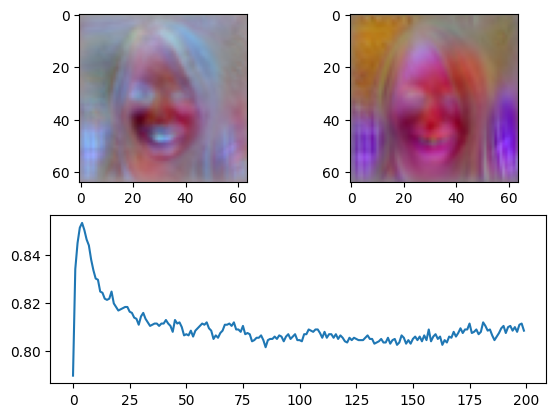

In [18]:
plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()

Результат по потерям весьма хорошо, но лицо расплывчато.

### Эксперимент 5

Поменяем оптимизатор.

In [19]:
def optimize0(w_coef1, w_coef2, source_latent, source_img_emb = torch.empty((0, 1)), epochs = 50, lr = 0.1):
    sg.eval()
    losses = []
    my_latent = copy_tensor(source_latent)
    text_emb = torch.cat([clip.tokenize(text)]).to(device2)
    optimizer = torch.optim.Adam([my_latent], lr = lr)
    cur_lr = copy(lr)
    real = bool(len(source_img_emb))
    
    for epoch in tqdm(range(epochs)):
        print(f"Итерация: {epoch}")
        if not real:
            source_img_emb, _ = sg([source_latent.to(device1)], input_is_latent = True)
        my_img_emb, _ = sg([my_latent.to(device1)], input_is_latent = True)
        loss = criterion(w_coef1, w_coef2, source_latent, my_latent, source_img_emb, my_img_emb, text_emb)
        optimizer.zero_grad()
        loss.backward()
        if len(losses):
            cur_lr = set_lr(lr, cur_lr, epoch / epochs)
        optimizer.param_groups[0]["lr"] = lr
        optimizer.step()
        losses.append(loss.item())
    
    my_img = my_img_emb.detach().cpu()
    return my_img, losses

In [20]:
img, losses = optimize0(w_coef1, w_coef2, lat, epochs = epochs, lr = lr)
img = torch.permute(img, (0, 2, 3, 1))

img = normalize(img)

  0%|          | 0/200 [00:00<?, ?it/s]

Итерация: 0
Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49
Итерация: 50
Итерация: 51
Итерация: 52
Итерация: 53
Итерация: 54
Итерация: 55
Итерация: 56
Итерация: 57
Итерация: 58
Итерация: 59
Итерация: 60
Итерация: 61
Итерация: 62
Итерация: 63
Итерация: 64
Итерация: 65
Итерация: 66
Итерация: 67
Итерация: 68
Итерация: 69
Итерация: 70
Итерация: 71
Итерация: 72
Итерация: 73
Итерация: 74
Итерация: 75
Итерация: 76
Итерация:

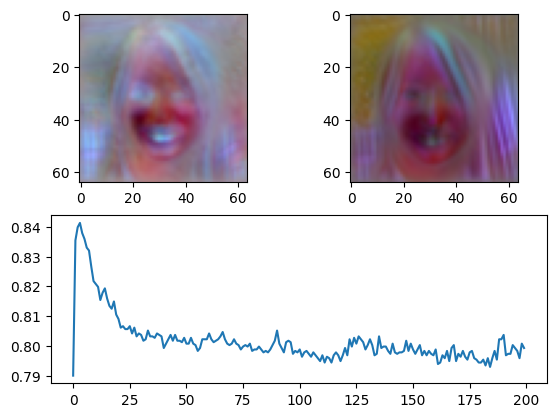

In [21]:
plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()

Модель работает чуть хуже предыдущей.

Результат: не всегда малые потери дают хорошую картинку.

## Реальные изображения

In [34]:
from PIL import Image
import torchvision.transforms as tf
import numpy as np

transform = tf.Compose([tf.Resize((224, 224)), tf.ToTensor(), tf.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

source_image = Image.open("1.jpg")

img0 = transform(source_image)

img, losses = optimize(w_coef1, w_coef2, lat, img0, epochs = epochs, lr = lr)
img = torch.permute(img, (0, 2, 3, 1))

img0 = normalize(img0)
img = normalize(img)

  0%|          | 0/200 [00:00<?, ?it/s]

Итерация: 0
Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49
Итерация: 50
Итерация: 51
Итерация: 52
Итерация: 53
Итерация: 54
Итерация: 55
Итерация: 56
Итерация: 57
Итерация: 58
Итерация: 59
Итерация: 60
Итерация: 61
Итерация: 62
Итерация: 63
Итерация: 64
Итерация: 65
Итерация: 66
Итерация: 67
Итерация: 68
Итерация: 69
Итерация: 70
Итерация: 71
Итерация: 72
Итерация: 73
Итерация: 74
Итерация: 75
Итерация: 76
Итерация:

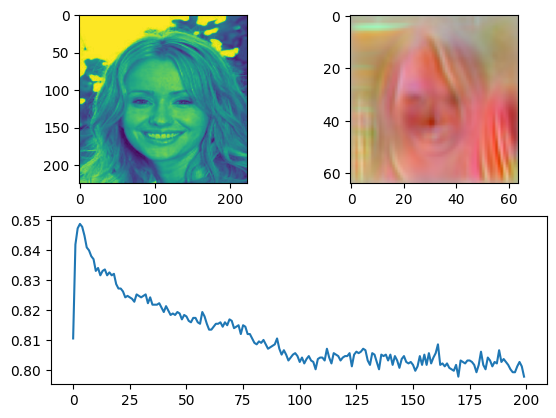

In [35]:
plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()

In [36]:
source_image = Image.open("2.jpg")

img0 = transform(source_image)

img, losses = optimize(w_coef1, w_coef2, lat, img0, epochs = epochs, lr = lr)
img = torch.permute(img, (0, 2, 3, 1))

img0 = normalize(img0)
img = normalize(img)

  0%|          | 0/200 [00:00<?, ?it/s]

Итерация: 0
Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49
Итерация: 50
Итерация: 51
Итерация: 52
Итерация: 53
Итерация: 54
Итерация: 55
Итерация: 56
Итерация: 57
Итерация: 58
Итерация: 59
Итерация: 60
Итерация: 61
Итерация: 62
Итерация: 63
Итерация: 64
Итерация: 65
Итерация: 66
Итерация: 67
Итерация: 68
Итерация: 69
Итерация: 70
Итерация: 71
Итерация: 72
Итерация: 73
Итерация: 74
Итерация: 75
Итерация: 76
Итерация:

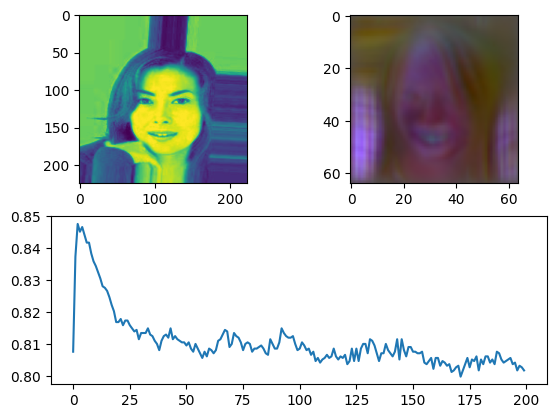

In [37]:
plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()

In [38]:
source_image = Image.open("3.jpg")

img0 = transform(source_image)

img, losses = optimize(w_coef1, w_coef2, lat, img0, epochs = epochs, lr = lr)
img = torch.permute(img, (0, 2, 3, 1))

img0 = normalize(img0)
img = normalize(img)

  0%|          | 0/200 [00:00<?, ?it/s]

Итерация: 0
Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49
Итерация: 50
Итерация: 51
Итерация: 52
Итерация: 53
Итерация: 54
Итерация: 55
Итерация: 56
Итерация: 57
Итерация: 58
Итерация: 59
Итерация: 60
Итерация: 61
Итерация: 62
Итерация: 63
Итерация: 64
Итерация: 65
Итерация: 66
Итерация: 67
Итерация: 68
Итерация: 69
Итерация: 70
Итерация: 71
Итерация: 72
Итерация: 73
Итерация: 74
Итерация: 75
Итерация: 76
Итерация:

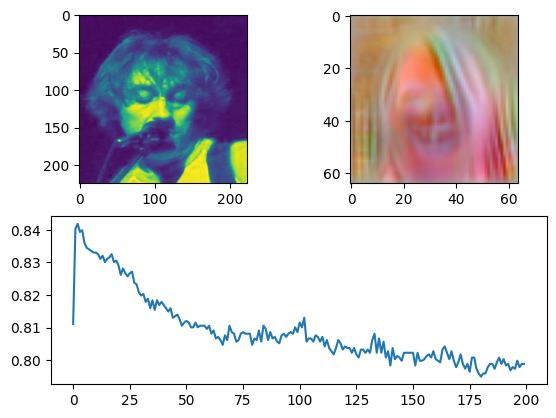

In [39]:
plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()

In [40]:
source_image = Image.open("4.jpg")

img0 = transform(source_image)

img, losses = optimize(w_coef1, w_coef2, lat, img0, epochs = epochs, lr = lr)
img = torch.permute(img, (0, 2, 3, 1))

img0 = normalize(img0)
img = normalize(img)

  0%|          | 0/200 [00:00<?, ?it/s]

Итерация: 0
Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49
Итерация: 50
Итерация: 51
Итерация: 52
Итерация: 53
Итерация: 54
Итерация: 55
Итерация: 56
Итерация: 57
Итерация: 58
Итерация: 59
Итерация: 60
Итерация: 61
Итерация: 62
Итерация: 63
Итерация: 64
Итерация: 65
Итерация: 66
Итерация: 67
Итерация: 68
Итерация: 69
Итерация: 70
Итерация: 71
Итерация: 72
Итерация: 73
Итерация: 74
Итерация: 75
Итерация: 76
Итерация:

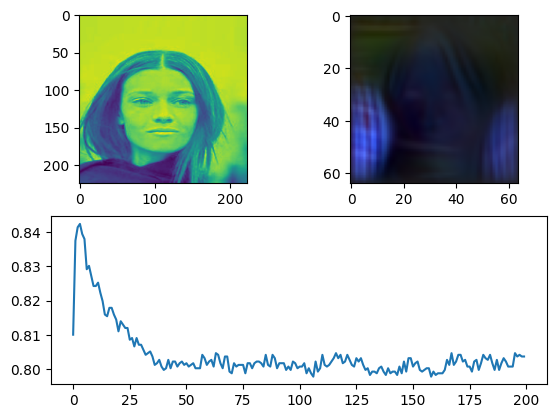

In [41]:
plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()

In [42]:
source_image = Image.open("5.jpg")

img0 = transform(source_image)

img, losses = optimize(w_coef1, w_coef2, lat, img0, epochs = epochs, lr = lr)
img = torch.permute(img, (0, 2, 3, 1))

img0 = normalize(img0)
img = normalize(img)

  0%|          | 0/200 [00:00<?, ?it/s]

Итерация: 0
Итерация: 1
Итерация: 2
Итерация: 3
Итерация: 4
Итерация: 5
Итерация: 6
Итерация: 7
Итерация: 8
Итерация: 9
Итерация: 10
Итерация: 11
Итерация: 12
Итерация: 13
Итерация: 14
Итерация: 15
Итерация: 16
Итерация: 17
Итерация: 18
Итерация: 19
Итерация: 20
Итерация: 21
Итерация: 22
Итерация: 23
Итерация: 24
Итерация: 25
Итерация: 26
Итерация: 27
Итерация: 28
Итерация: 29
Итерация: 30
Итерация: 31
Итерация: 32
Итерация: 33
Итерация: 34
Итерация: 35
Итерация: 36
Итерация: 37
Итерация: 38
Итерация: 39
Итерация: 40
Итерация: 41
Итерация: 42
Итерация: 43
Итерация: 44
Итерация: 45
Итерация: 46
Итерация: 47
Итерация: 48
Итерация: 49
Итерация: 50
Итерация: 51
Итерация: 52
Итерация: 53
Итерация: 54
Итерация: 55
Итерация: 56
Итерация: 57
Итерация: 58
Итерация: 59
Итерация: 60
Итерация: 61
Итерация: 62
Итерация: 63
Итерация: 64
Итерация: 65
Итерация: 66
Итерация: 67
Итерация: 68
Итерация: 69
Итерация: 70
Итерация: 71
Итерация: 72
Итерация: 73
Итерация: 74
Итерация: 75
Итерация: 76
Итерация:

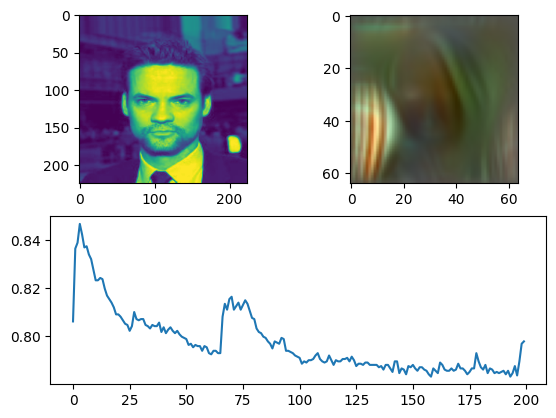

In [43]:
plt.subplot(2, 2, 1)
plt.imshow(img0[0])
plt.subplot(2, 2, 2)
plt.imshow(img[0])
plt.subplot(2, 1, 2)
plt.plot(range(epochs), losses)
plt.show()